  # KLASYFIKACJA LICZB Z BIBLIOTEKI MNIST

potrzebne biblioteki:

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# od razu ustawimy stałe ziarno losowości:
def set_seed(seed):
    torch.manual_seed(seed)            # PyTorch CPU
    torch.cuda.manual_seed(seed)       # PyTorch GPU
    torch.backends.cudnn.deterministic = True # wymusza deterministyczne algorytmy
    torch.backends.cudnn.benchmark = False  # zapobiega losowym optymalizacjom które mogą zmienić wynik

set_seed(7)

Pobieramy dane, transformujemy je w tensory i od razu normalizujemy

In [2]:
# ładujemy MNIST
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

# pobieramy wszystkie obrazy (Mnist jest na tyle małe że możemy wszystkie naraz, bez batchy)
data, _ = next(iter(loader))

mean = data.mean().item()
std = data.std().item()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.95MB/s]


## Zacznijmy od przygotowania funkcji do trenowania i testowania dwóch modeli które będziemy chcieli porównać:

In [3]:
def train(model, device, train_loader, optimizer, history):
    model.train()
    total_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    avg_loss = total_loss / len(train_loader.dataset)
    acc = 100. * correct / len(train_loader.dataset)
    history['train_loss'].append(avg_loss)
    history['train_acc'].append(acc)

Wykorzystamy w naszym przypadku entropię krzyżową jako funkcję straty a optimizerem będzie początkowo Adam, potencjalnie będziemy mogli go zmienić

In [4]:
def test(model, device, test_loader, history):
    model.eval()
    test_loss = 0
    correct = 0
    preds = []
    labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            preds.extend(pred.cpu().numpy())
            labels.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    history['val_loss'].append(test_loss)
    history['val_acc'].append(acc)
    return test_loss, acc, preds, labels


Aby przy każdym modeli i jego usprawnieniu nie wklejać całego kodu stworzymy funkcję do trenowania modeli

In [5]:
def training(model,optimizer,epochs,plots = True):
  history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

  for epoch in range(1, epochs + 1):
      train(model, device, train_loader, optimizer, history)
      loss, acc, preds, labels = test(model, device, test_loader, history)
      print(f"Epoch {epoch}: Test loss={loss:.4f}, Accuracy={acc:.2f}%")

  # Przebieg uczenia
  if plots == True:
    plt.figure(figsize=(12,5))
    plt.plot(history['train_loss'], label="train loss")
    plt.plot(history['val_loss'], label="val loss")
    plt.xlabel("Epoka")
    plt.ylabel("Strata")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.plot(history['train_acc'], label="train acc")
    plt.plot(history['val_acc'], label="val acc")
    plt.xlabel("Epoka")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


    # Macierz pomyłek
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    print(classification_report(labels, preds, digits=4))

    # Wizualizacja predykcji
    model.eval()
    data_iter = iter(test_loader)
    images_batch, targets = next(data_iter)
    images_batch, targets = images_batch.to(device), targets.to(device)
    outputs = model(images_batch)
    preds = outputs.argmax(dim=1)

    fig, axes = plt.subplots(2, 5, figsize=(12,5))
    for idx, ax in enumerate(axes.flat):
        ax.imshow(images_batch[idx].cpu().squeeze(), cmap="gray")
        ax.set_title(f"True:{targets[idx].item()} / Pred:{preds[idx].item()}", color=("green" if preds[idx]==targets[idx] else "red"))
        ax.axis("off")
    plt.show()

### Najpierw stwórzmy prostą sieć i sprawdźmy jak nam pójdzie:

In [7]:
class BASELINE(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

Epoch 1: Test loss=0.1150, Accuracy=96.55%
Epoch 2: Test loss=0.0851, Accuracy=97.31%
Epoch 3: Test loss=0.0739, Accuracy=97.71%
Epoch 4: Test loss=0.0812, Accuracy=97.50%
Epoch 5: Test loss=0.0772, Accuracy=97.73%
Epoch 6: Test loss=0.0701, Accuracy=98.03%
Epoch 7: Test loss=0.0768, Accuracy=97.91%
Epoch 8: Test loss=0.0913, Accuracy=97.70%
Epoch 9: Test loss=0.1163, Accuracy=97.33%
Epoch 10: Test loss=0.1027, Accuracy=97.56%


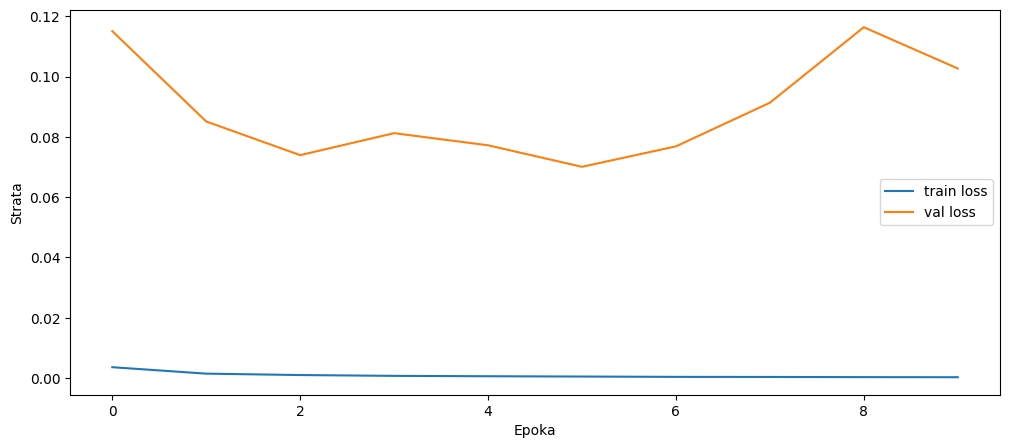

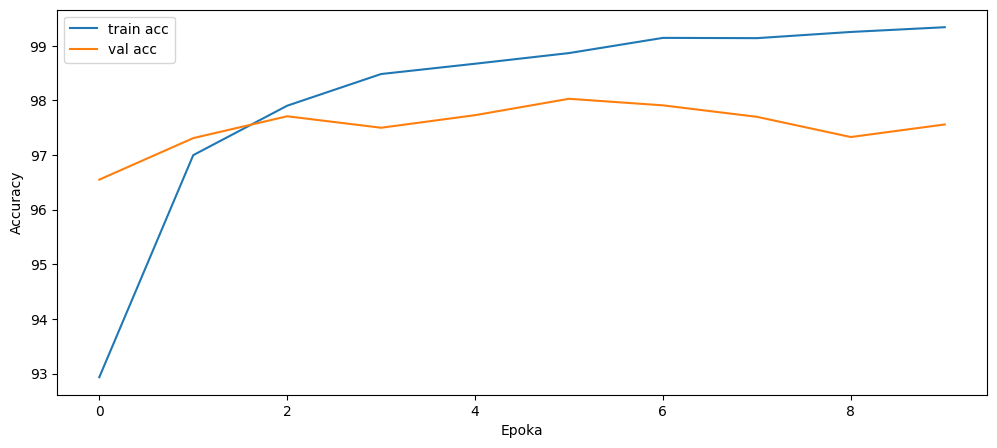

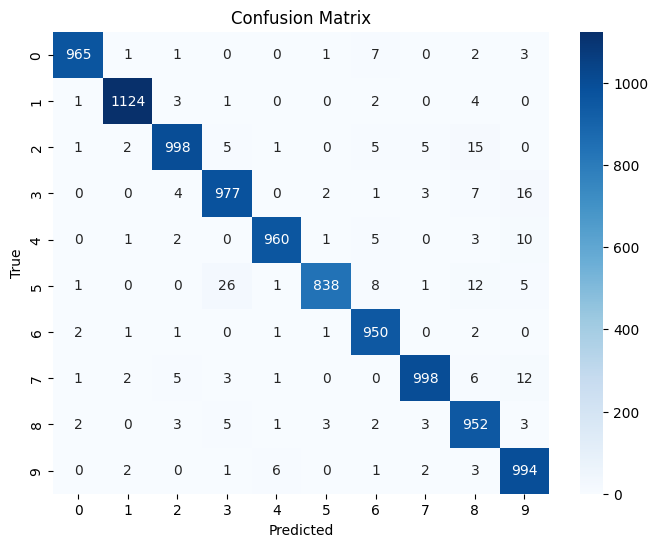

              precision    recall  f1-score   support

           0     0.9918    0.9847    0.9882       980
           1     0.9921    0.9903    0.9912      1135
           2     0.9813    0.9671    0.9741      1032
           3     0.9597    0.9673    0.9635      1010
           4     0.9887    0.9776    0.9831       982
           5     0.9905    0.9395    0.9643       892
           6     0.9684    0.9916    0.9799       958
           7     0.9862    0.9708    0.9784      1028
           8     0.9463    0.9774    0.9616       974
           9     0.9530    0.9851    0.9688      1009

    accuracy                         0.9756     10000
   macro avg     0.9758    0.9751    0.9753     10000
weighted avg     0.9759    0.9756    0.9756     10000



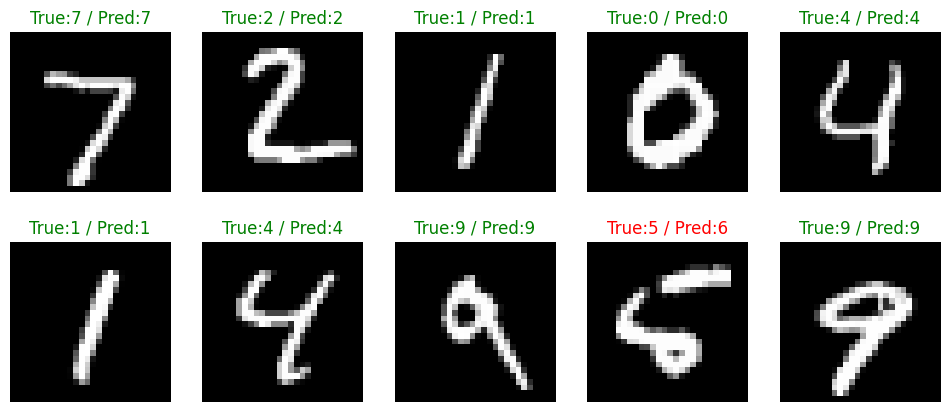

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BASELINE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

training(model,optimizer,epochs)

Tak prosty model daje całkiem niezłe wyniki, nie mniej confusion matrix pokazuje że niektóre liczby są mylone. Na przykład 4 jest mylone z 9 lub 5 z 3. Pomimo że pomyłki te są niemalże marginalne to i tak postaramy się zrobić wynik blisko idealnego bardziej skomplikowanym modelem.

## Model nr. 2:


Do tego typu obrazów dobrze sprawdzą się warstwy konwolucyjne (Conv2d)

In [16]:
class BETTER_MODEL(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)     # 1 kanał wejściowy - obrazek mnist, 32 filtry, kernel 3 i padding 1 aby macierz wag nie zmniejszyła obrazu
        self.bn1 = nn.BatchNorm2d(32)       # normalizacja cech

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)    # wejście 32 kanały, wyjście 64
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)  # redukcja zdjęcia o połowę (z 28x28 na 14x14)
        self.fc1 = nn.Linear(64*14*14, 128)
        self.fc2 = nn.Linear(128, 10)   # redukcja do 10 cech
        self.dropout = nn.Dropout(0.25)     # żeby zapobiec overfittingowi odrzucamy 25% neuronów podczas treningu

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)

przeprowadzimy teraz tą samą analizę na naszym nowym modelu

Epoch 1: Test loss=0.0583, Accuracy=98.17%
Epoch 2: Test loss=0.0354, Accuracy=98.75%
Epoch 3: Test loss=0.0385, Accuracy=98.88%
Epoch 4: Test loss=0.0346, Accuracy=98.96%
Epoch 5: Test loss=0.0347, Accuracy=99.00%
Epoch 6: Test loss=0.0389, Accuracy=98.76%
Epoch 7: Test loss=0.0348, Accuracy=99.00%
Epoch 8: Test loss=0.0349, Accuracy=99.02%
Epoch 9: Test loss=0.0346, Accuracy=99.06%
Epoch 10: Test loss=0.0307, Accuracy=99.25%


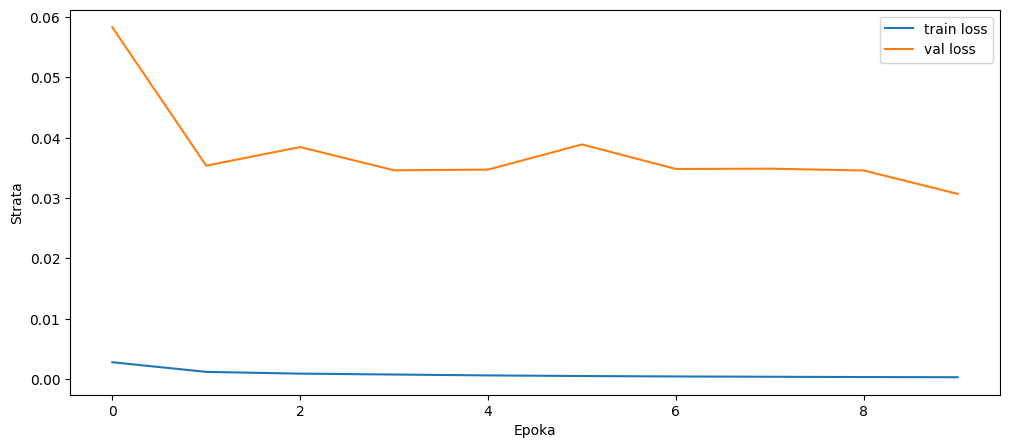

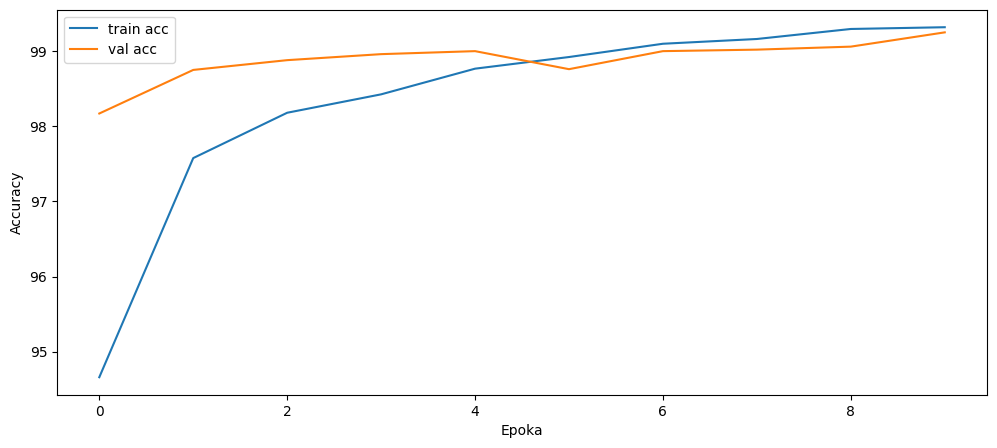

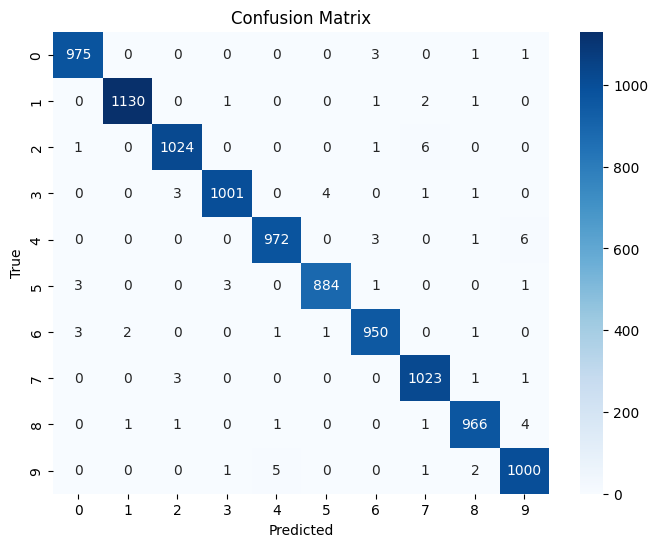

              precision    recall  f1-score   support

           0     0.9929    0.9949    0.9939       980
           1     0.9974    0.9956    0.9965      1135
           2     0.9932    0.9922    0.9927      1032
           3     0.9950    0.9911    0.9931      1010
           4     0.9928    0.9898    0.9913       982
           5     0.9944    0.9910    0.9927       892
           6     0.9906    0.9916    0.9911       958
           7     0.9894    0.9951    0.9922      1028
           8     0.9918    0.9918    0.9918       974
           9     0.9872    0.9911    0.9891      1009

    accuracy                         0.9925     10000
   macro avg     0.9925    0.9924    0.9924     10000
weighted avg     0.9925    0.9925    0.9925     10000



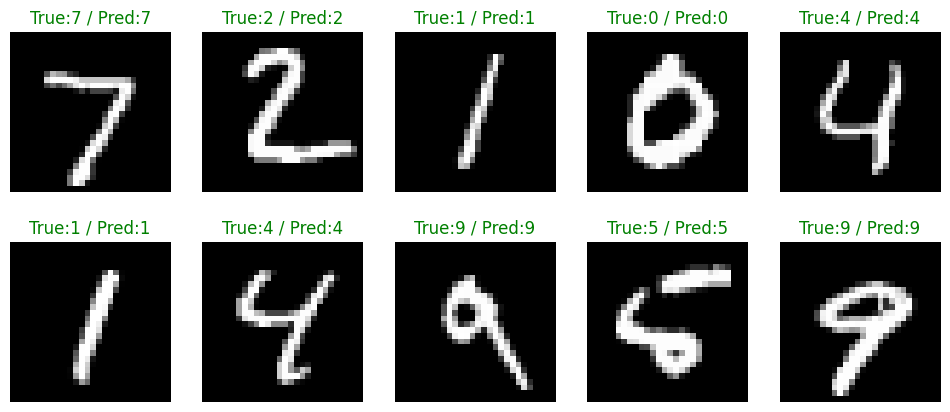

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BETTER_MODEL().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10
training(model,optimizer,epochs)

# Wynik lepszy o niecały p.procentowy, możemy jeszcze spróbować dostroić hiperparametry:

Zacznijmy od sprawdzenia innych optymalizatorów takich jak SGD (Stochastic Gradient Descent)

In [18]:
model = BETTER_MODEL().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
epochs = 10
training(model,optimizer,epochs,False)

Epoch 1: Test loss=0.0471, Accuracy=98.46%
Epoch 2: Test loss=0.0394, Accuracy=98.65%
Epoch 3: Test loss=0.0384, Accuracy=98.77%
Epoch 4: Test loss=0.0363, Accuracy=98.84%
Epoch 5: Test loss=0.0262, Accuracy=99.22%
Epoch 6: Test loss=0.0402, Accuracy=98.78%
Epoch 7: Test loss=0.0279, Accuracy=99.17%
Epoch 8: Test loss=0.0322, Accuracy=99.16%
Epoch 9: Test loss=0.0294, Accuracy=99.13%
Epoch 10: Test loss=0.0328, Accuracy=99.12%


Możemy zobaczyć, że accuracy już od 1 epoki jest wyższe niż dla Adama i wraz z kolejnymi epokami wzrasta, ale z wahaniami. Zwiększę liczbę epoch aby sprawdzić czy tendencja będzie się utrzymywać

Epoch 1: Test loss=0.0494, Accuracy=98.39%
Epoch 2: Test loss=0.0419, Accuracy=98.67%
Epoch 3: Test loss=0.0357, Accuracy=98.88%
Epoch 4: Test loss=0.0325, Accuracy=99.02%
Epoch 5: Test loss=0.0305, Accuracy=99.13%
Epoch 6: Test loss=0.0325, Accuracy=99.04%
Epoch 7: Test loss=0.0332, Accuracy=99.18%
Epoch 8: Test loss=0.0309, Accuracy=99.13%
Epoch 9: Test loss=0.0345, Accuracy=99.06%
Epoch 10: Test loss=0.0335, Accuracy=99.13%
Epoch 11: Test loss=0.0314, Accuracy=99.23%
Epoch 12: Test loss=0.0321, Accuracy=99.16%
Epoch 13: Test loss=0.0322, Accuracy=99.22%
Epoch 14: Test loss=0.0377, Accuracy=98.98%
Epoch 15: Test loss=0.0368, Accuracy=99.14%
Epoch 16: Test loss=0.0297, Accuracy=99.20%
Epoch 17: Test loss=0.0360, Accuracy=99.08%
Epoch 18: Test loss=0.0369, Accuracy=99.25%
Epoch 19: Test loss=0.0351, Accuracy=99.17%
Epoch 20: Test loss=0.0361, Accuracy=99.20%
Epoch 21: Test loss=0.0395, Accuracy=99.08%
Epoch 22: Test loss=0.0353, Accuracy=99.25%
Epoch 23: Test loss=0.0363, Accuracy=99.1

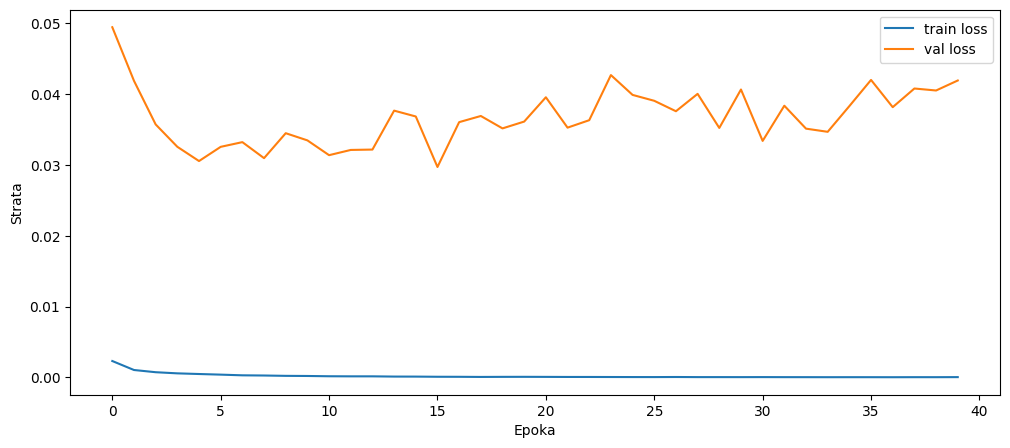

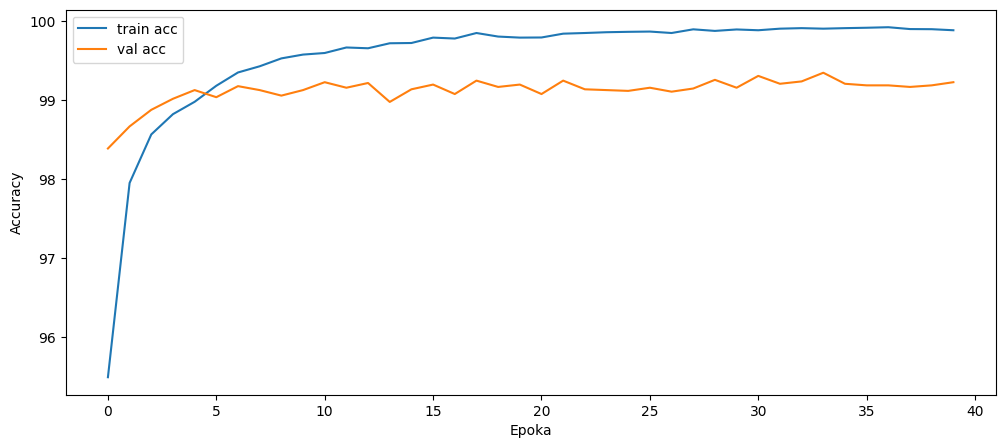

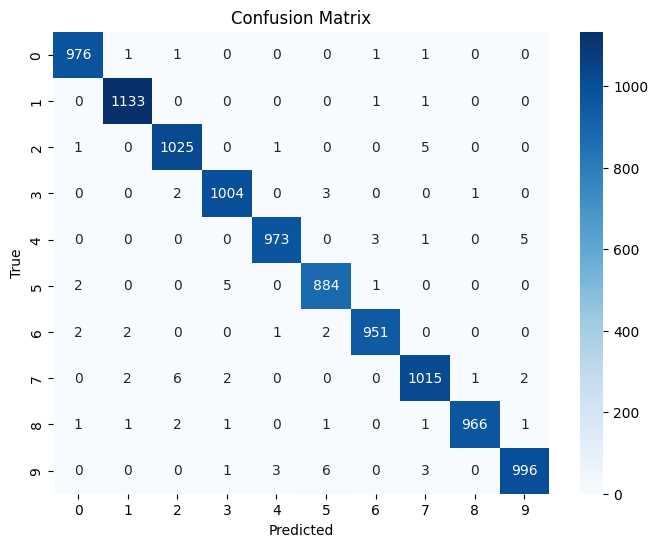

              precision    recall  f1-score   support

           0     0.9939    0.9959    0.9949       980
           1     0.9947    0.9982    0.9965      1135
           2     0.9894    0.9932    0.9913      1032
           3     0.9911    0.9941    0.9926      1010
           4     0.9949    0.9908    0.9929       982
           5     0.9866    0.9910    0.9888       892
           6     0.9937    0.9927    0.9932       958
           7     0.9883    0.9874    0.9878      1028
           8     0.9979    0.9918    0.9949       974
           9     0.9920    0.9871    0.9896      1009

    accuracy                         0.9923     10000
   macro avg     0.9923    0.9922    0.9922     10000
weighted avg     0.9923    0.9923    0.9923     10000



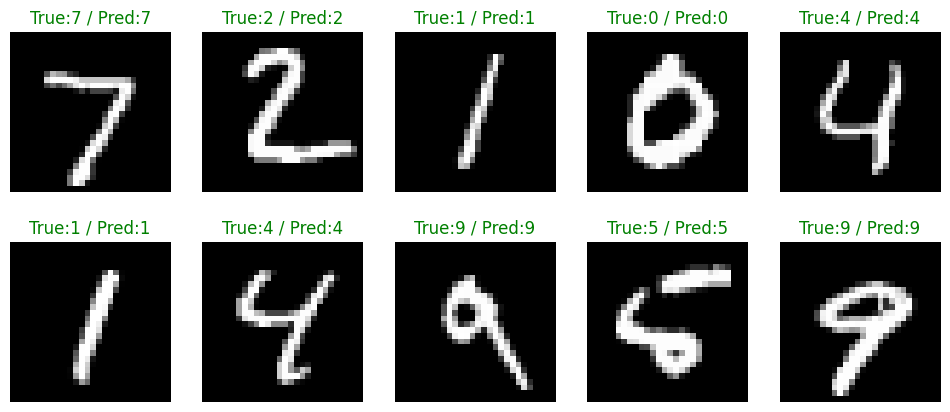

In [31]:
epochs = 40
model = BETTER_MODEL().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
training(model,optimizer,epochs,True)

Możemy zauważyć na wykresie, że na całej przestrzeni wykresu epok następują wahania, dla większej liczby accuracy jest nieznacznie większe ale również wachania się powiększają. Nie widzę powodu, aby zmieniać w takim przypadku liczby epok.


Drugi hiperparametr który weźmiemy pod uwagę to learning rate. Sprawdzimy kilka potencjalnych wartości dla lr

In [32]:
lr_list = [0.1, 0.05, 0.01, 0.005, 0.001]
results = {}

for i in lr_list:
    print(f"\n=== learning rate: {i} ===")

    # Nowy model dla każdego lr
    model = BETTER_MODEL().to(device)
    optimizer = optim.SGD(model.parameters(), lr=i, momentum=0.9, nesterov=True)
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss": [], "val_loss": [],
               "train_acc": [], "val_acc": []}

    best_val_acc = 0.0

    for epoch in range(10):
        train(model, device, train_loader, optimizer, history)
        test(model, device, test_loader, history)

        val_acc = history["val_acc"][-1]
        if val_acc > best_val_acc:
            best_val_acc = val_acc

    results[i] = best_val_acc

print("\n Wyniki ")
for lr, acc in results.items():
    print(f"lr={lr} → best val_acc={acc:.4f}")



=== learning rate: 0.1 ===

=== learning rate: 0.05 ===

=== learning rate: 0.01 ===

=== learning rate: 0.005 ===

=== learning rate: 0.001 ===

 Wyniki 
lr=0.1 → best val_acc=19.0000
lr=0.05 → best val_acc=98.7500
lr=0.01 → best val_acc=99.2500
lr=0.005 → best val_acc=99.1400
lr=0.001 → best val_acc=99.0500


Okazuje sie, że początkowo dobrane hiperparametry okazały się jednymi z lepszych. Częściowo dzieje się tak przez dokładność bliską 100% gdzie operujemy na przedziale dziesiątych procenta, mimo wszystko udało nam się poprzez bardziej rozbudowany model osiągnąć lepsze wyniki niż baseline.

## Podsumowując: Przebiliśmy prosty model baseline, drugim modelem bardziej skomplikowanym, uwzględniającym tematykę problemu. Pomimo poszukiwania optymalnych hiperparametrów, te "najbardziej intuicyjne i książkowe" okazały się jednymi z lepszych między innymi przez prostotę problemu i niezwykle wysoką dokładność modeli.